# Modeling a Recurrent Neuronal Network

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import os
import joblib
from copy import deepcopy as dc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [2]:
data_dir = '../Data/Processed'
time_series = {}

for file in os.listdir(data_dir):
    if file.endswith('.parquet'):
        file_path = os.path.join(data_dir, file)
        key = os.path.splitext(file)[0]
        key = key.replace('processed_', '')
        key = key.replace('_', ' ').title()

        time_series[key] = pd.read_parquet(file_path)
    
time_series.keys()

dict_keys(['Cargo Private', 'Passenger Truck Public', 'Auto Private', 'Total', 'Cargo Public', 'Passenger Truck Private', 'Auto Public'])

## Tensors

In [3]:
ts_tensors = {}

for key in time_series.keys():
    df = dc(time_series[key])
    split_idx = int(len(df)*0.8)
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    X_train = train_df.drop(columns=['X']).to_numpy()
    y_train = train_df['X'].to_numpy()

    X_test = test_df.drop(columns=['X']).to_numpy()
    y_test = test_df['X'].to_numpy()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 12, 1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 12, 1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    ts_tensors[key] = {
        'X_train': X_train_tensor,
        'y_train': y_train_tensor,
        'X_test': X_test_tensor,
        'y_test': y_test_tensor,
    }
    print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)


torch.Size([322, 12, 1]) torch.Size([322, 1]) torch.Size([81, 12, 1]) torch.Size([81, 1])
torch.Size([322, 12, 1]) torch.Size([322, 1]) torch.Size([81, 12, 1]) torch.Size([81, 1])
torch.Size([322, 12, 1]) torch.Size([322, 1]) torch.Size([81, 12, 1]) torch.Size([81, 1])
torch.Size([322, 12, 1]) torch.Size([322, 1]) torch.Size([81, 12, 1]) torch.Size([81, 1])
torch.Size([322, 12, 1]) torch.Size([322, 1]) torch.Size([81, 12, 1]) torch.Size([81, 1])
torch.Size([322, 12, 1]) torch.Size([322, 1]) torch.Size([81, 12, 1]) torch.Size([81, 1])
torch.Size([322, 12, 1]) torch.Size([322, 1]) torch.Size([81, 12, 1]) torch.Size([81, 1])


## DataSet, DataLoader

In [4]:
class TimeSerieDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
batch_size = 16
ts_dataloader = {}

for key in ts_tensors.keys():
    tensors = dc(ts_tensors[key])
    
    X_train = tensors['X_train']
    y_train = tensors['y_train']

    X_test = tensors['X_test']
    y_test = tensors['y_test']

    train_dataset = TimeSerieDataset(X_train, y_train)
    test_dataset = TimeSerieDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    ts_dataloader[key] = {
        'train' : train_loader,
        'test' : test_loader
    }

## LSTM

In [6]:
class LSTM_ts(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 64, num_layers = 2, outputs_size = 1, dropout = 0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm  = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, outputs_size)
    
    def forward (self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}
loss_fn = {}
optimizer = {}

for key in ts_dataloader.keys():

    model = LSTM_ts().to(device)
    models[key] = model

    loss_fn[key] = nn.MSELoss()
    optimizer[key] = torch.optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [8]:
loss_history = {}

for key in ts_dataloader.keys():
    model = models[key]
    model.train()
    loss_history[key] = []

    for epoch in range(10):
        epoch_loss = 0.0

        for X_batch, y_batch in ts_dataloader[key]['train']:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward
            output = model(X_batch)
            loss = loss_fn[key](output, y_batch)

            # Backward
            optimizer[key].zero_grad()
            loss.backward()
            optimizer[key].step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss/len(ts_dataloader[key]['train'])
        loss_history[key].append(avg_loss)

        print(f"Serie: {key} | Epoch [{epoch+1}/10] | Loss: {avg_loss:.6f}")

Serie: Cargo Private | Epoch [1/10] | Loss: 0.558818
Serie: Cargo Private | Epoch [2/10] | Loss: 0.086963
Serie: Cargo Private | Epoch [3/10] | Loss: 0.012190
Serie: Cargo Private | Epoch [4/10] | Loss: 0.008051
Serie: Cargo Private | Epoch [5/10] | Loss: 0.005233
Serie: Cargo Private | Epoch [6/10] | Loss: 0.004725
Serie: Cargo Private | Epoch [7/10] | Loss: 0.003328
Serie: Cargo Private | Epoch [8/10] | Loss: 0.002838
Serie: Cargo Private | Epoch [9/10] | Loss: 0.002348
Serie: Cargo Private | Epoch [10/10] | Loss: 0.002170
Serie: Passenger Truck Public | Epoch [1/10] | Loss: 0.281763
Serie: Passenger Truck Public | Epoch [2/10] | Loss: 0.053778
Serie: Passenger Truck Public | Epoch [3/10] | Loss: 0.038256
Serie: Passenger Truck Public | Epoch [4/10] | Loss: 0.023017
Serie: Passenger Truck Public | Epoch [5/10] | Loss: 0.020800
Serie: Passenger Truck Public | Epoch [6/10] | Loss: 0.020743
Serie: Passenger Truck Public | Epoch [7/10] | Loss: 0.021633
Serie: Passenger Truck Public | Epo

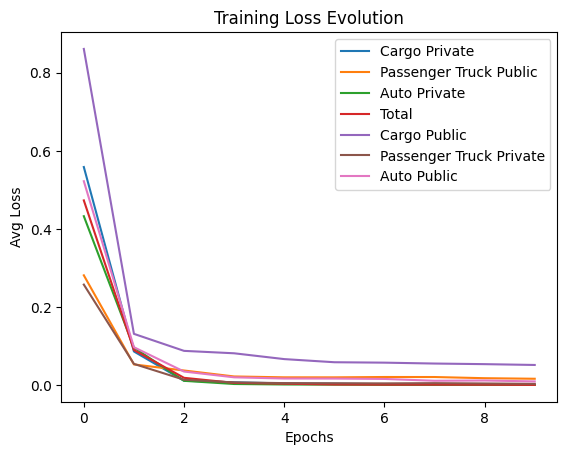

In [9]:
for key, losses in loss_history.items():
    plt.plot(losses, label=key)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Avg Loss")
plt.title("Training Loss Evolution")
plt.savefig('../Outputs/Figures/05-training_loss.png')
plt.show()

## Model Evaluation

In [10]:
eval_results = {}

for key in ts_dataloader.keys():
    model = models[key]
    model.eval()

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for X_batch, y_batch in ts_dataloader[key]['test']:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)

            y_true_all.append(y_batch.cpu().numpy())
            y_pred_all.append(y_pred.cpu().numpy())

    y_true_all = np.concatenate(y_true_all).flatten()
    y_pred_all = np.concatenate(y_pred_all).flatten()

    mse = mean_squared_error(y_true=y_true_all, y_pred=y_pred_all)
    rmse = np.sqrt(mse)

    eval_results[key] = {
        'MSE': mse,
        'RMSE': rmse,
        'y_true': y_true_all,
        'y_pred': y_pred_all
    }
    print(f"Serie: {key} | MSE: {mse:.6f} | RMSE: {rmse:.6f}")

Serie: Cargo Private | MSE: 0.006254 | RMSE: 0.079083
Serie: Passenger Truck Public | MSE: 2.416167 | RMSE: 1.554402
Serie: Auto Private | MSE: 0.023807 | RMSE: 0.154294
Serie: Total | MSE: 0.023748 | RMSE: 0.154103
Serie: Cargo Public | MSE: 0.061951 | RMSE: 0.248900
Serie: Passenger Truck Private | MSE: 1.497909 | RMSE: 1.223891
Serie: Auto Public | MSE: 0.014764 | RMSE: 0.121506


In [12]:
preds_dir = '../Outputs/Predictions'
scaler_dir = '../Outputs/Models/Scalers'
os.makedirs(preds_dir, exist_ok=True)

for key in eval_results.keys():
    y_true_scaled = eval_results[key]['y_true']
    y_pred_scaled = eval_results[key]['y_pred']

    scaler_path = os.path.join(scaler_dir, f'scaler_{key.replace(' ', '_').lower()}.save')
    scaler = joblib.load(scaler_path)

    y_true_inv = scaler.inverse_transform(y_true_scaled.reshape(-1,1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

    df_test = dc(time_series[key].iloc[int(len(time_series[key])*0.8):])
    df_eval = pd.DataFrame({
        'Date':df_test.index,
        'Real':y_true_inv,
        'Pred':y_pred_inv
    })

    df_eval.to_parquet(os.path.join(preds_dir, f'eval_pred_{key.replace(' ', '_').lower()}.parquet'), index=False)
    


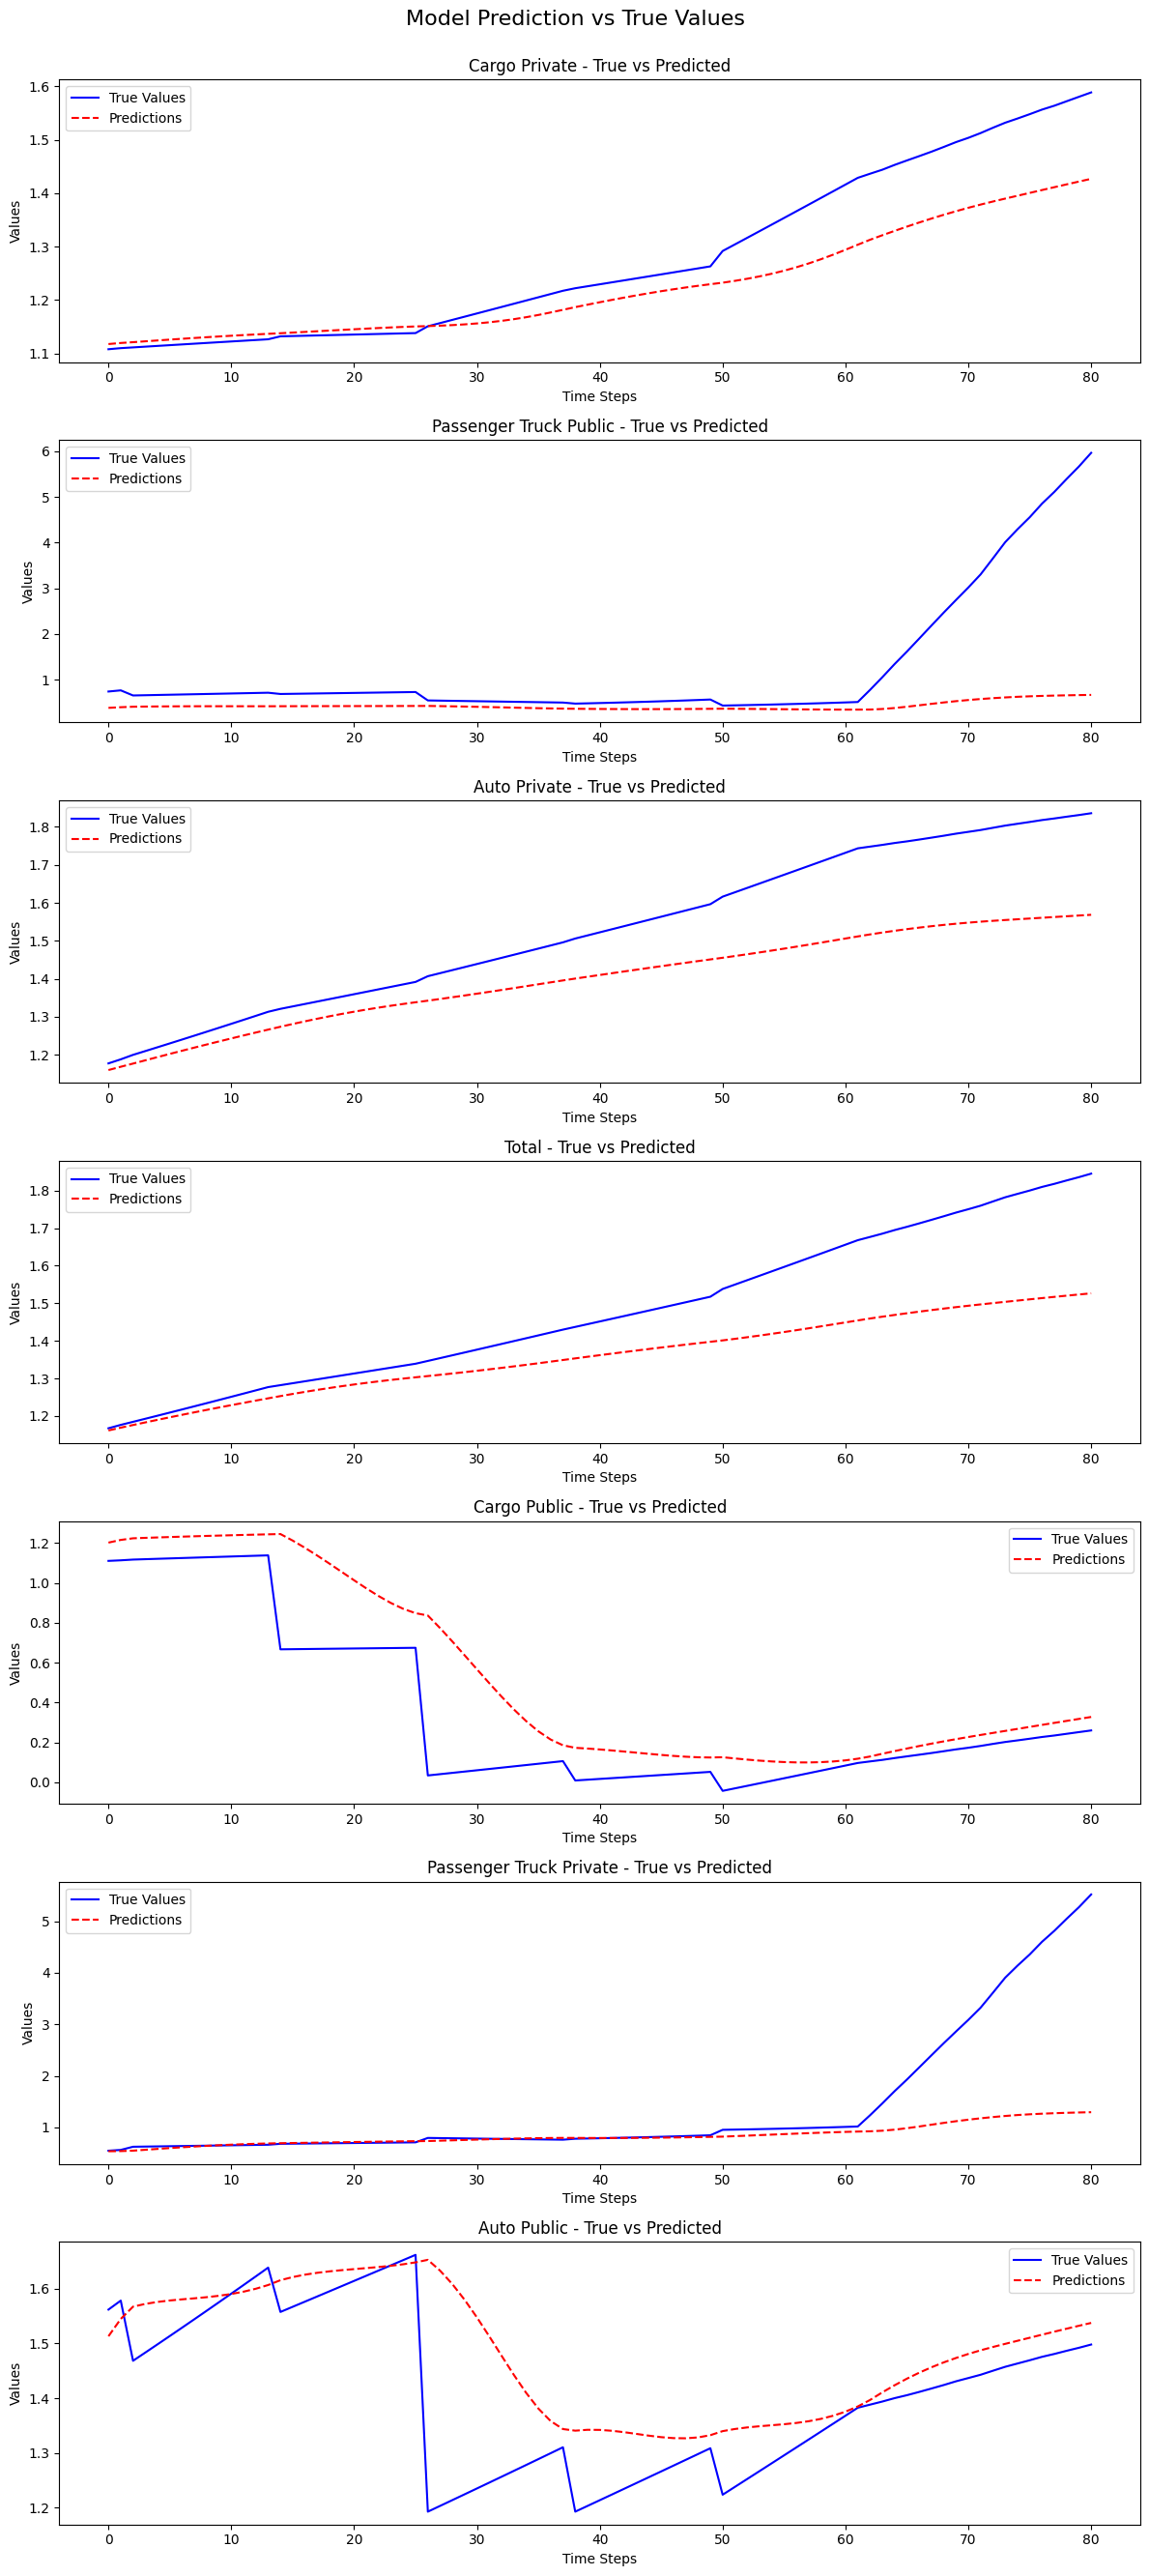

In [13]:
n = len(eval_results.keys())
fig, axes = plt.subplots(n, 1, figsize=(12, 4*n))
fig.suptitle("Model Prediction vs True Values", fontsize=16)

for i, key in enumerate(eval_results.keys()):
    y_true = eval_results[key]['y_true']
    y_pred = eval_results[key]['y_pred']

    axes[i].plot(y_true, label='True Values', color='blue')
    axes[i].plot(y_pred, label='Predictions', color='red', linestyle='--')
    axes[i].set_title(f"{key} - True vs Predicted")
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Values")
    axes[i].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('../Outputs/Figures/06-predictions_vs_true.png')
plt.show()

## Saving the Model

In [14]:
os.makedirs('../Outputs/Models/LSTM/', exist_ok=True)
for key in models.keys():
    model = models[key]
    model_path = f'../Outputs/Models/LSTM/model_{key.replace(" ", "_").lower()}.pth'
    torch.save(model.state_dict(), model_path)